<a href="https://colab.research.google.com/github/maren-ha/DimensionReductionForScRNASeq/blob/main/DimensionReduction_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimension reduction for single-cell RNA-seq data 

### MeInBio Methods Snack, February 27, 2023

***Maren Hackenberg***

## What's it all about? 

- Intro 
- Taking a closer look 
  - PCA 
  - UMAP
  - tSNE
  - scVI
- Seeing them in action 

## Introduction 

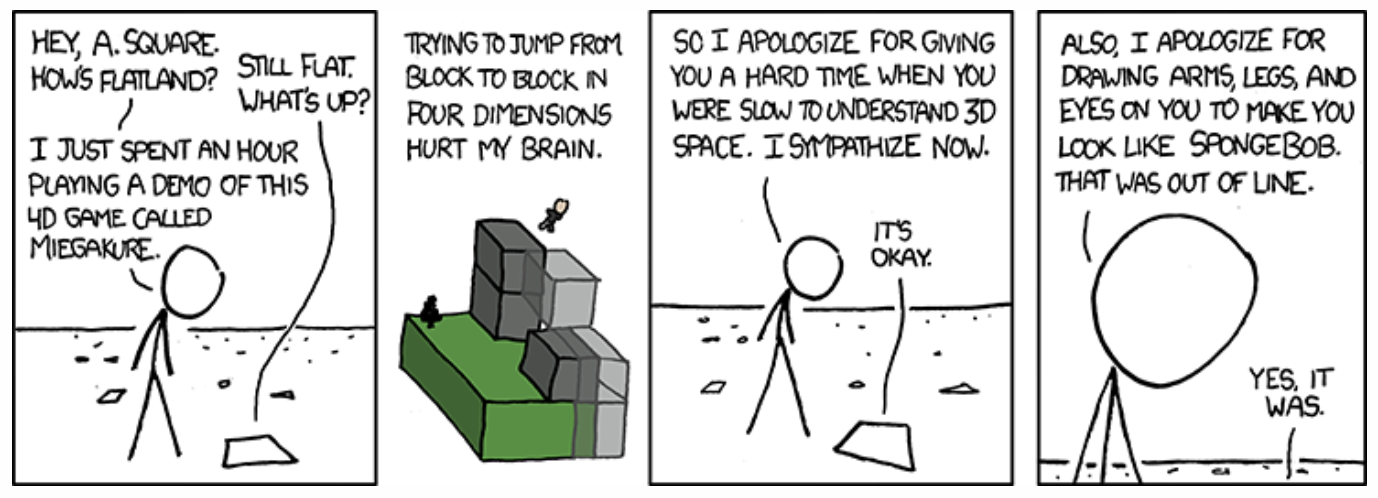

## Some examples from papers 

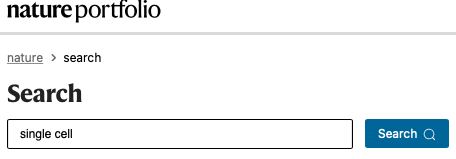

**Fig. 4a from [Zheng, M., Hu, Z., Mei, X. et al. Single-cell sequencing shows cellular heterogeneity of cutaneous lesions in lupus erythematosus. Nat Commun 13, 7489 (2022).](https://doi.org/10.1038/s41467-022-35209-1)**

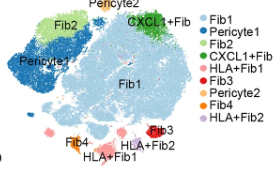

**Fig. 2a,b from [Cao, K., Gong, Q., Hong, Y. et al. A unified computational framework for single-cell data integration with optimal transport. Nat Commun 13, 7419 (2022).](https://doi.org/10.1038/s41467-022-35094-8)**

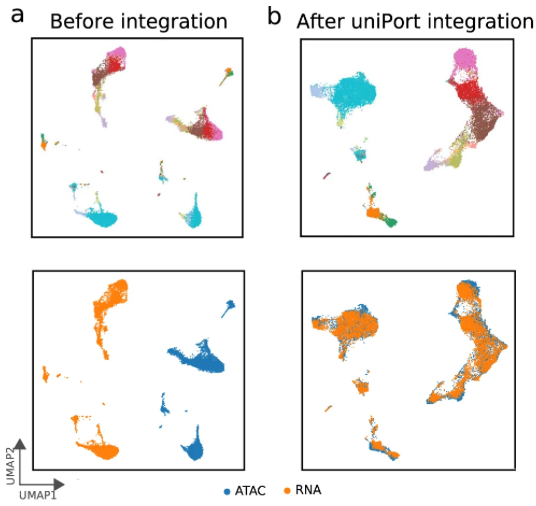

**Fig. 1e-j from [Vistain, L., Van Phan, H., Keisham, B. et al. Quantification of extracellular proteins, protein complexes and mRNAs in single cells by proximity sequencing. Nat Methods 19, 1578–1589 (2022).](https://doi.org/10.1038/s41592-022-01684-z)**

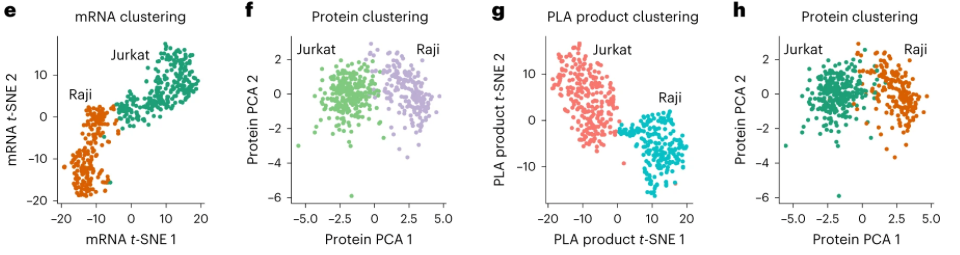

**Fig. 1d from [Jessa, S., Mohammadnia, A., Harutyunyan, A.S. et al. K27M in canonical and noncanonical H3 variants occurs in distinct oligodendroglial cell lineages in brain midline gliomas. Nat Genet (2022).](https://doi.org/10.1038/s41588-022-01205-w)**

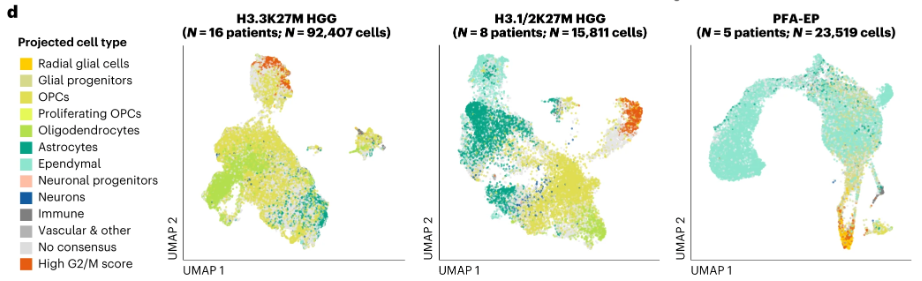



## Getting some data

In [ ]:
# pip install ipykernel
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install anndata
!{sys.executable} -m pip install scvi-tools
!{sys.executable} -m pip install umap-learn 
!{sys.executable} -m pip install scanpy
!{sys.executable} -m pip install scikit-misc
!{sys.executable} -m pip install leidenalg

**1) Download data:**

In [19]:
import os 
#os.chdir("/Users/imbi-mac-102/Desktop/MeInBioProject/MethodsSnack/")

In [ ]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write

**2) Initialise `AnnData` object**

In [21]:
import anndata 
import numpy as np 
import scanpy as sc
import pandas as pd 

results_file = "data/pbmc3k.h5ad"
adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",                # use gene symbols for the variable names (variables-axis index)
    cache=True)
adata.var_names_make_unique()
adata.raw = adata
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Some basic preprocessing 

**Show genes with highest fraction of counts in each single cell and do basic filtering:**

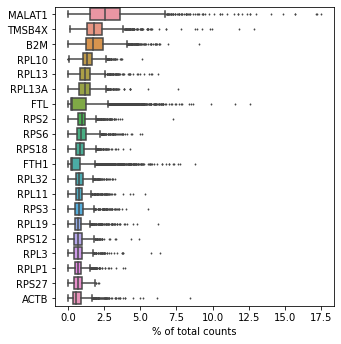

In [22]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [23]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

**Some quality control metrics:**

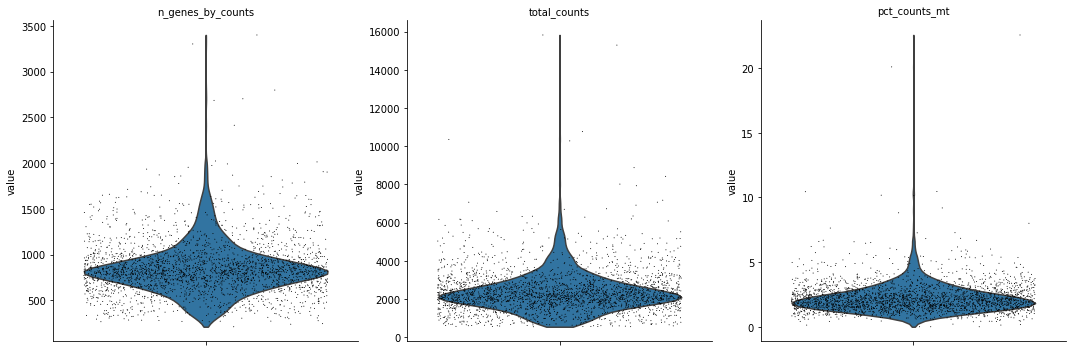

In [24]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

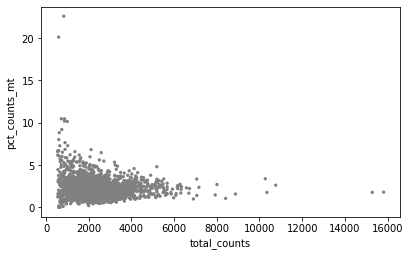

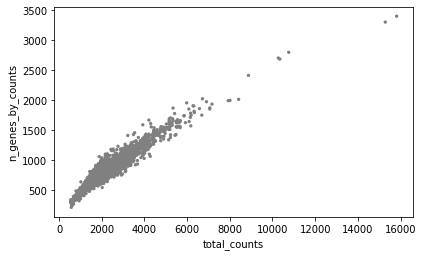

In [25]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

**Remove cells with too many mitochondrial genes expressed or too many total counts:**

In [26]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

**Normalize and log-transform:**

In [27]:
adata.layers["counts"] = adata.X
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [28]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'
    layers: 'counts'

**Identify highly variable genes:** 

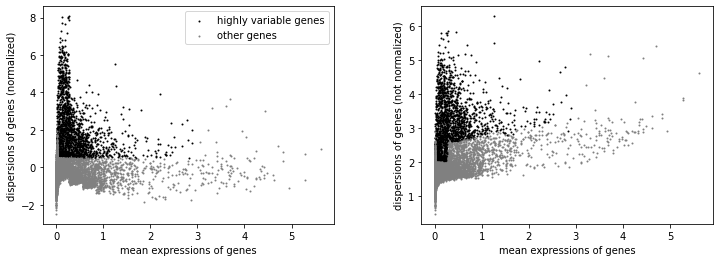

In [29]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [30]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [31]:
adata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490
...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,1153,3459.0,73.0,2.110436
TTTCTACTGAGGCA-1,1227,1224,3443.0,32.0,0.929422
TTTCTACTTCCTCG-1,622,622,1684.0,37.0,2.197150
TTTGCATGAGAGGC-1,454,452,1022.0,21.0,2.054795


In [32]:
adata.var

,gene_ids,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000237683,9,False,9,0.003333,99.666667,9.0,False,0.013556,1.432845,-0.624328
AP006222.2,ENSG00000228463,3,False,3,0.001111,99.888889,3.0,False,0.004696,1.458631,-0.573416
RP11-206L10.2,ENSG00000228327,5,False,5,0.001852,99.814815,5.0,False,0.005673,1.325459,-0.836359
RP11-206L10.9,ENSG00000237491,3,False,3,0.001111,99.888889,3.0,False,0.002644,0.859264,-1.756848
LINC00115,ENSG00000225880,18,False,18,0.006667,99.333333,18.0,False,0.027437,1.457477,-0.575693
...,...,...,...,...,...,...,...,...,...,...,...
AC145212.1,ENSG00000215750,16,False,16,0.006667,99.407407,18.0,False,0.027441,1.784637,0.070275
AL592183.1,ENSG00000220023,323,False,323,0.134815,88.037037,364.0,False,0.485051,1.859941,-0.437388
AL354822.1,ENSG00000215615,8,False,8,0.002963,99.703704,8.0,False,0.012157,1.781924,0.064919
PNRC2-1,ENSG00000215700,110,False,110,0.042963,95.925926,116.0,False,0.160366,1.567491,-0.358474


In [33]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata)
#sc.tl.paga(adata)
#sc.pl.paga(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


The result of the previous highly-variable-genes detection is stored as an annotation in `.var.highly_variable` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools. In that case, the step "actually do the filtering" below is unnecessary, too.

In [34]:
# actually do the filtering
# adata = adata[:, adata.var.highly_variable]
# sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
# sc.pp.scale(adata, max_value=10)

In [35]:
#import pandas as pd
#import numpy as np
#cluster_labels = pd.read_csv("data/pbmc8k/PBMC8k_clust_annotation.csv", dtype="str", usecols=["x"])
# PBMC8k 
# data downloaded from https://www.10xgenomics.com/resources/datasets/8-k-pbm-cs-from-a-healthy-donor-2-standard-2-0-1 ("gene-cell matrix filtered")
#adata_pbmc = anndata.read_csv("data/pbmc8k/PBMC8k_counts.csv")
#adata_pbmc.layers["log_counts"] = np.log1p(adata_pbmc.X)
#adata_pbmc.layers["counts"] = adata_pbmc.X
#adata_pbmc.obs["cell_type"] = cluster_labels
#adata_pbmc

## Principal Component Analysis (PCA)

For a detailed explanation, I can recommend this: 
https://www.huber.embl.de/msmb/Chap-Multivariate.html#dimension-reduction 

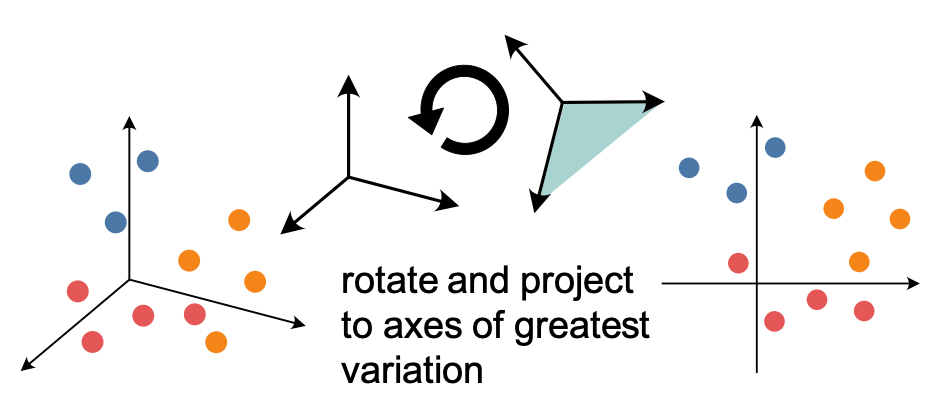

### Not every projection is equally informative

Compare the following 2D projections of a 3D object (an animal, in this case.) Which do you find more informative, and why? 

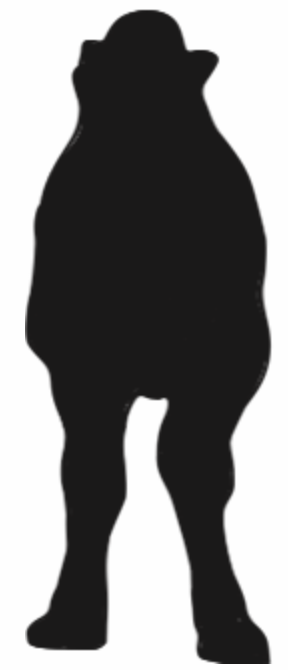

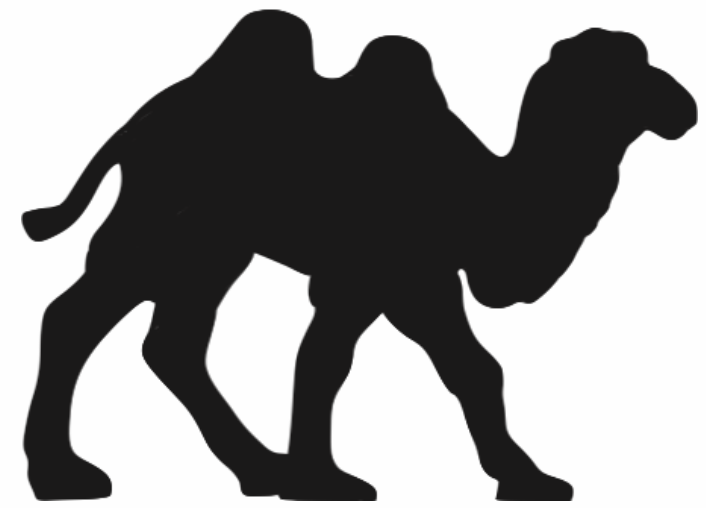

PCA is designed to identify a "maximally informative transformation": It takes the high-dimensional data and rotates it such that the rotated data columns correspond to the axes that encode the most variance in the data. 

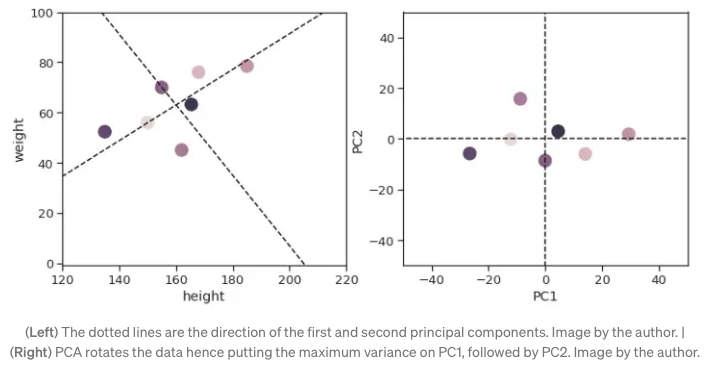

(taken from https://towardsdatascience.com/principal-component-analysis-pca-explained-visually-with-zero-math-1cbf392b9e7d)


In this case, the data is two-dimensional. If our data is higher-dimensional, PCA does exactly the same thing, but we cannot visualise the data anymore. PCA always rotates our entire data matrix, so in principle there are as many PCs as there are variables in out dataset. 
To visualise our data using PCA, we therefore only keep the first two principal components, that encode the two "directions" along which most variance in the data happens. This means we are losing some information, because some "left-over" variance also happens in the other PCs other than the first two. To understand the effect of this, we can look at the toy example again, and pretend we want to keep only the first PC for visualisation (this corresponds to having data that is higher-dimensional and reducing it to two dimensions). When keeping only the first PC, we would need to project all data points onto that first PC: 

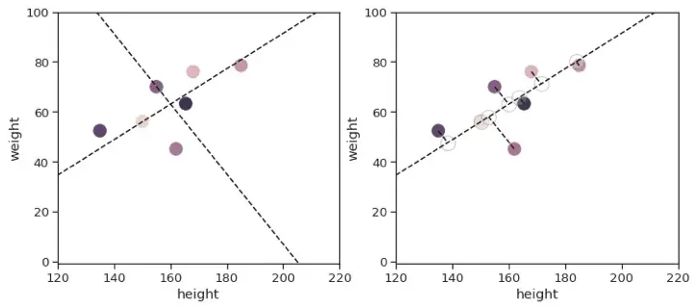

This idea exactly corresponds to the intro with the animal shape: It is a 3D-"object", and we make a 2D-visualisation of it by rotation and projection to 2D, ideally in a way that keeps most information about the object, i.e., that captures most variance. 

PCA in itself is a linear transformation, specifically a rotation. That means the rotation in itself does not alter distances between points. However, the projection to fewer dimensions changes distances between data points, because there is always some variation happening in other dimensions that we do not visualise. This variation affects the distances between points, and by projecting to lower dimensions, the distances become distorted because the difference in these other, "discarded" dimensions "gets lost": 

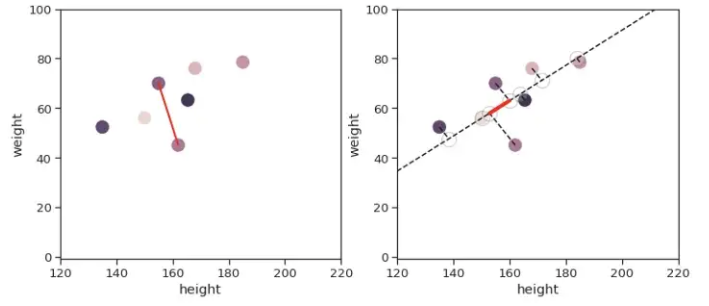 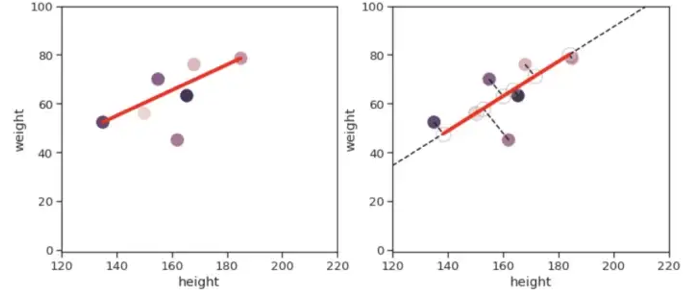

Points whose distance is mainly driven by differences in the second principal component (that we do not want to incorporate in our visualisation) appear much closer in the 1D-representation than in the original 2D-representation. This affects smaller distances more than larger distances: PCA is designed to keep the dimensions along which most variation happens. That means for points with large pairwise distances, these distances will roughly be captured by the first PCs, because PCA is specifically designed to capture the dimensions with large difference (=much variation) in the first PCs. As a result, smaller distances get distorted more than large distances. This is why it is often said that PCA preserves global distances well, but does not really preserve local distances. 

**So let's look at it!**

In [36]:
sc.tl.pca(adata, n_comps=100, svd_solver='arpack')
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'neighbors', 'leiden', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

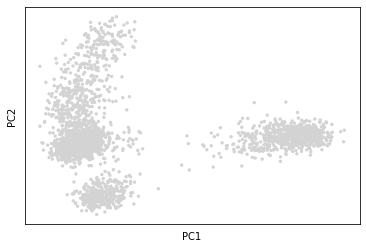

In [37]:
sc.pl.pca(adata)

In [38]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'neighbors', 'leiden', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

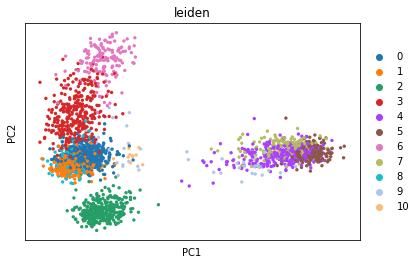

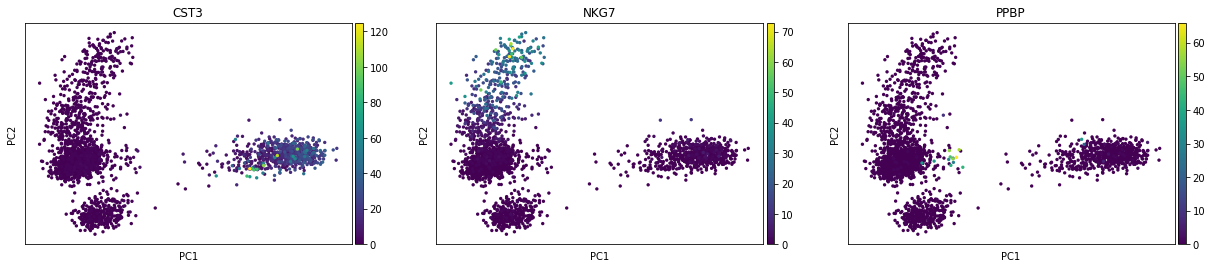

In [48]:
sc.pl.pca(adata, color='leiden')
sc.pl.pca(adata, color=['CST3', 'NKG7', 'PPBP'])

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function `sc.tl.louvain()` or tSNE `sc.tl.tsne()` (typically a rough estimate of the number of PCs does fine).

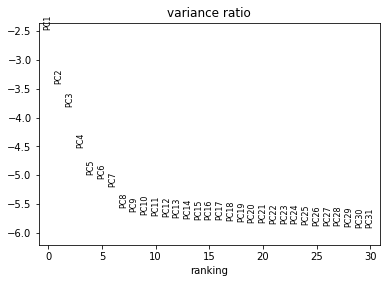

In [40]:
sc.pl.pca_variance_ratio(adata, log=True)

In [41]:
adata.write(results_file)

## t-distributed stochastic neighbourhood embedding (tSNE)

[van der Maaten, L. and Hinton, G. Visualizing data using t-SNE, JMLR 9, 2579-2605 (2008).](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)

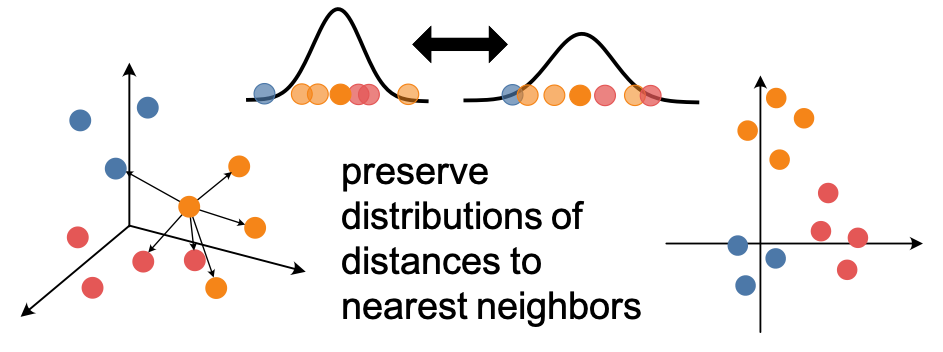

In [42]:
sc.tl.tsne(adata, 
            n_pcs=10, #10
            perplexity=20, #30 
            early_exaggeration=12, #12 
            learning_rate=200, #1000
            random_state=6, #0
            metric="euclidean"
)
adata

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'neighbors', 'leiden', 'pca', 'leiden_colors', 'tsne'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

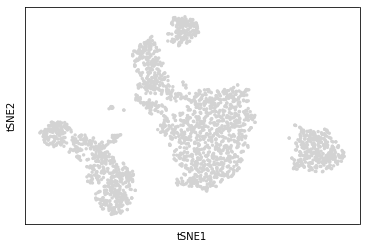

In [43]:
sc.pl.tsne(adata)

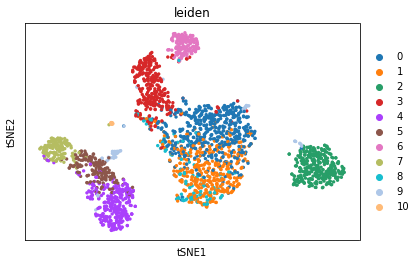

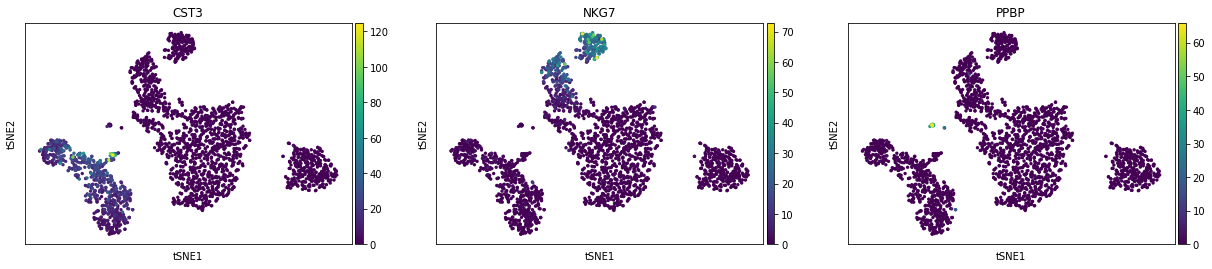

In [44]:
sc.pl.tsne(adata, color='leiden')
sc.pl.tsne(adata, color=['CST3', 'NKG7', 'PPBP'])

## Uniform Manifold Approximation and Projection (UMAP)

[McInnes, L., Healy, J., Saul, N., Großberger, L. UMAP: Uniform manifold approximation and projection, Journal of Open Source Software, 3(29), 861 (2018)](https://doi.org/10.21105/joss.00861)

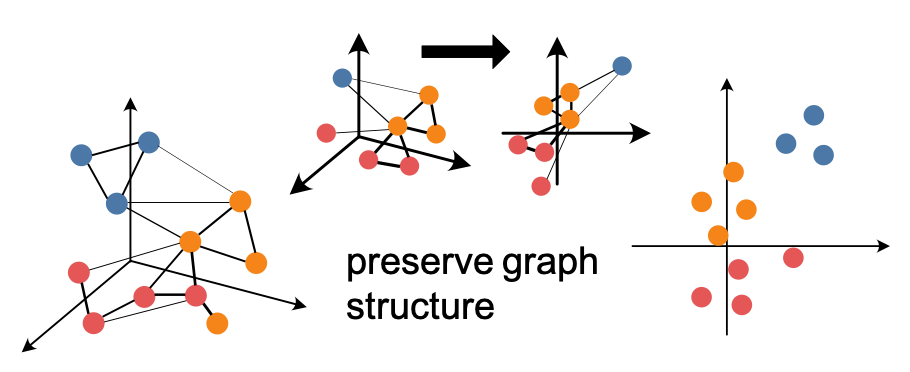


In [45]:
sc.pp.neighbors(adata, n_neighbors=15, 
                n_pcs=20, 
                random_state=0, 
                metric='euclidean')
sc.tl.umap(adata, 
            min_dist=0.1, #3 # 0.1
            spread=0.3, #0.5
            alpha=1, 
            gamma=1, 
            negative_sample_rate=5
)
adata

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'neighbors', 'leiden', 'pca', 'leiden_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

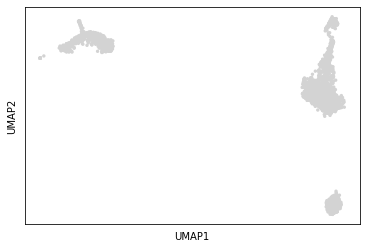

In [46]:
sc.pl.umap(adata)

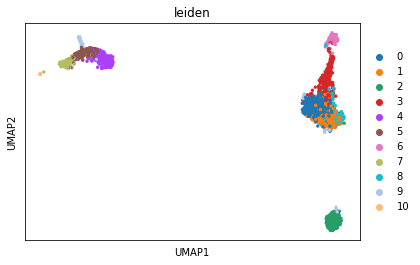

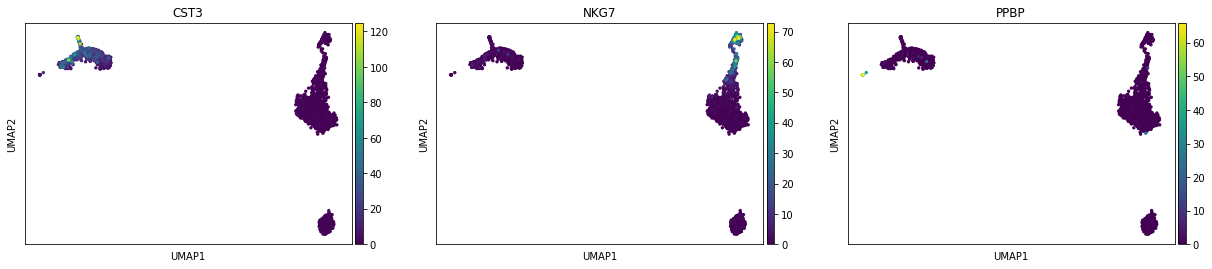

In [47]:
sc.pl.umap(adata, color='leiden')
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

## Single-cell Variational Inference (scVI)

[Lopez, R., Regier, J., Cole, M.B. et al. Deep generative modeling for single-cell transcriptomics. Nat Methods 15, 1053–1058 (2018).](https://doi.org/10.1038/s41592-018-0229-2)

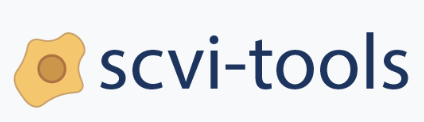

Part of the [`scvi-tools`](https://scvi-tools.org) universe: [Gayoso, A., Lopez, R., Xing, G. et al. A Python library for probabilistic analysis of single-cell omics data. Nat Biotechnol 40, 163–166 (2022).](https://doi.org/10.1038/s41587-021-01206-w).

Many tutorials and extensive documentation can be found [here](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/api_overview.html). 

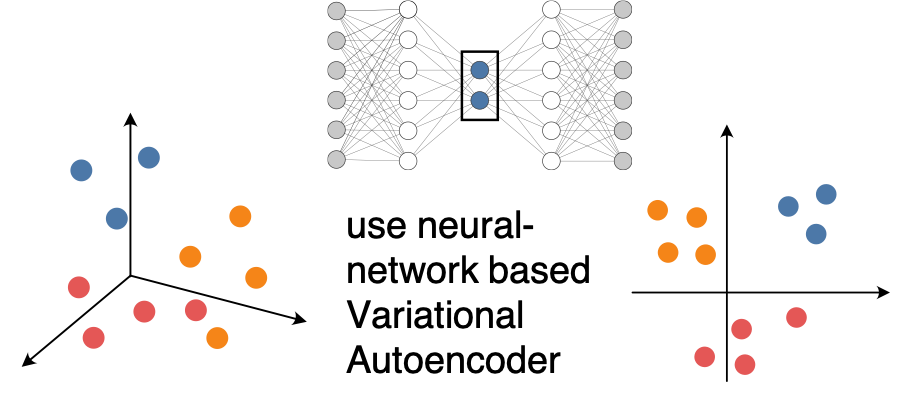

**How it works in a bit more detail:**

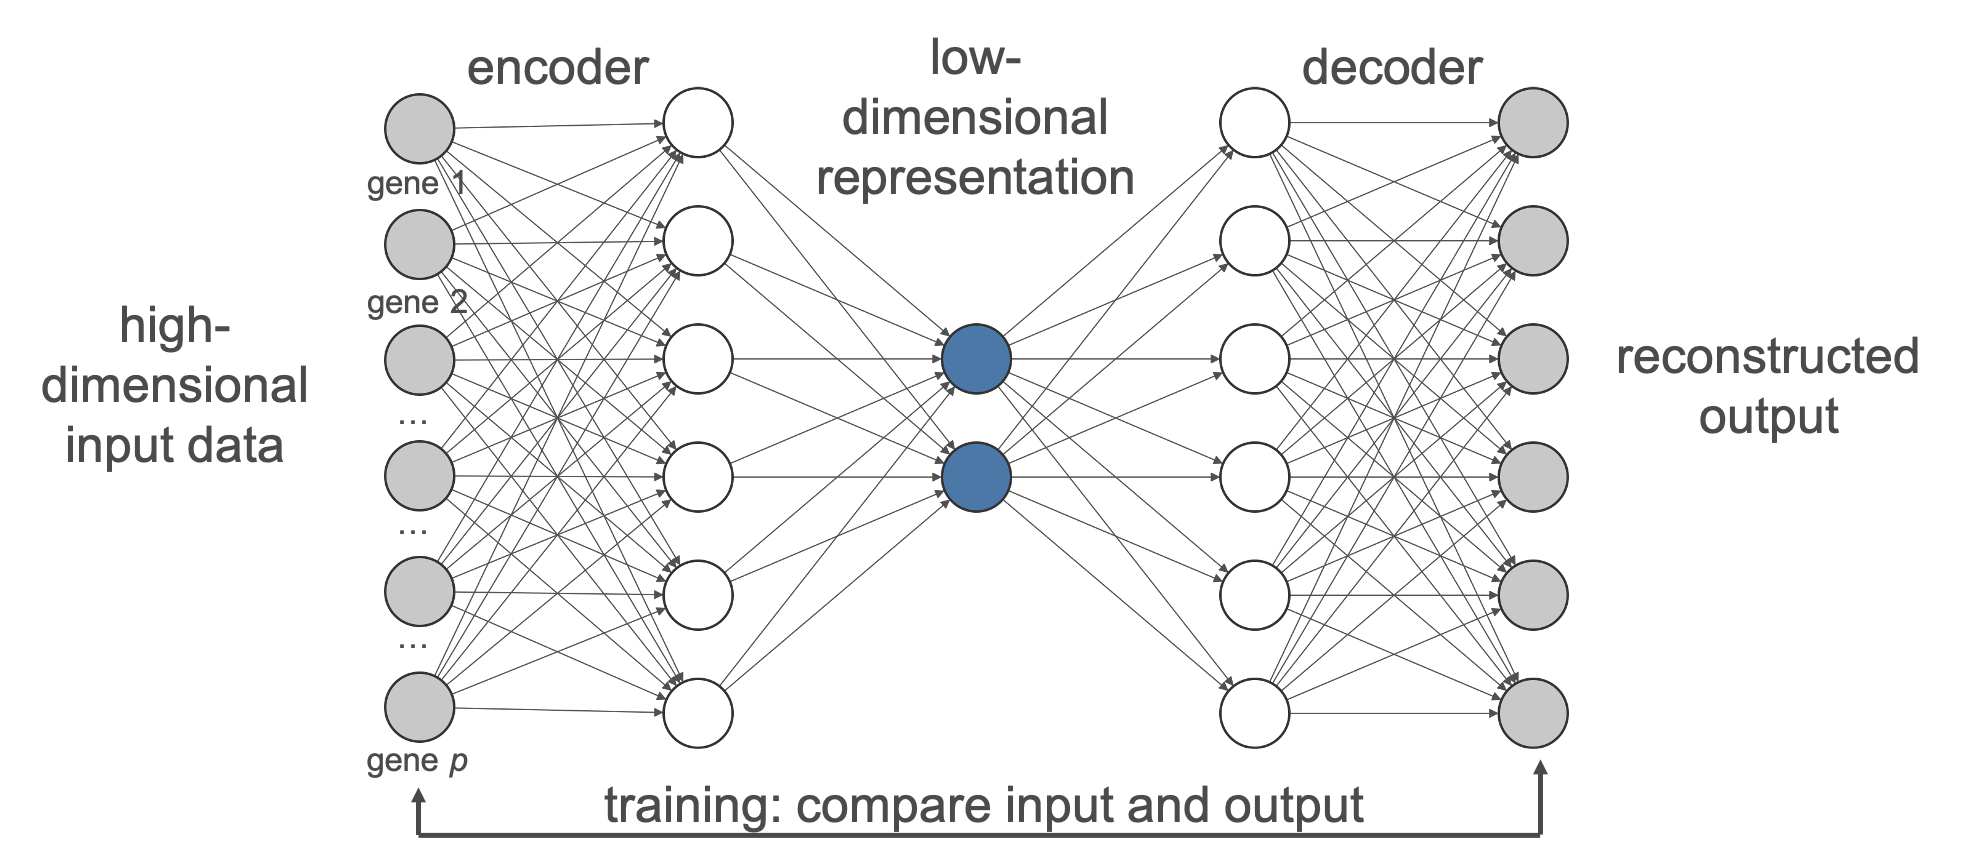

**Pros** 
* very flexible 
* learns an explicit mapping as a function, that means new datapoints can easily be projected into the same learned embedding (possible also with PCA, for tSNE and UMAP the embedding needs to be re-trained)
* customisable loss functions allow to specifically enforce different properties of the latent space (e.g., that latent dimensions are disentangled, correct for batch effects, etc.)
* operates on raw counts, such that less pre-processing is required 

**Cons**
* many hyperparameters, including choice of network architecture 
* typically only a (one of several) local optimum is found, training does not necessarily converge
* typically a two-dimensional space may not be comprehensive enough, but a higher-dimensional representation is used (e.g., 10 dimensions) and UMAP is calculated on top of that 

>**WARNING:** For some reason, the `scvi` package currently does not install on Google colab. So the following code only works in Jupyter as of now. 

In [49]:
adata_scvi = adata.copy()
adata_scvi

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'neighbors', 'leiden', 'pca', 'leiden_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [ ]:
import scvi

In [ ]:
sc.pp.highly_variable_genes(
    adata_scvi,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    subset=True
)
adata_scvi

In [ ]:
scvi.model.SCVI.setup_anndata(adata_scvi, layer="counts")

In [52]:
vae = scvi.model.SCVI(adata_scvi, n_layers=2, n_latent=2, gene_likelihood="nb")

NameError: ignored

In [ ]:
vae.train(max_epochs=100, use_gpu=False)

In [ ]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

In [ ]:
sc.pl.embedding(
    adata,
    basis="X_scVI",
    frameon=False,
    ncols=1,
    color="leiden"
)

Finally, a little advertisement: All this is also available in Julia (in case you're a fan :D):

https://github.com/maren-ha/scVI.jl

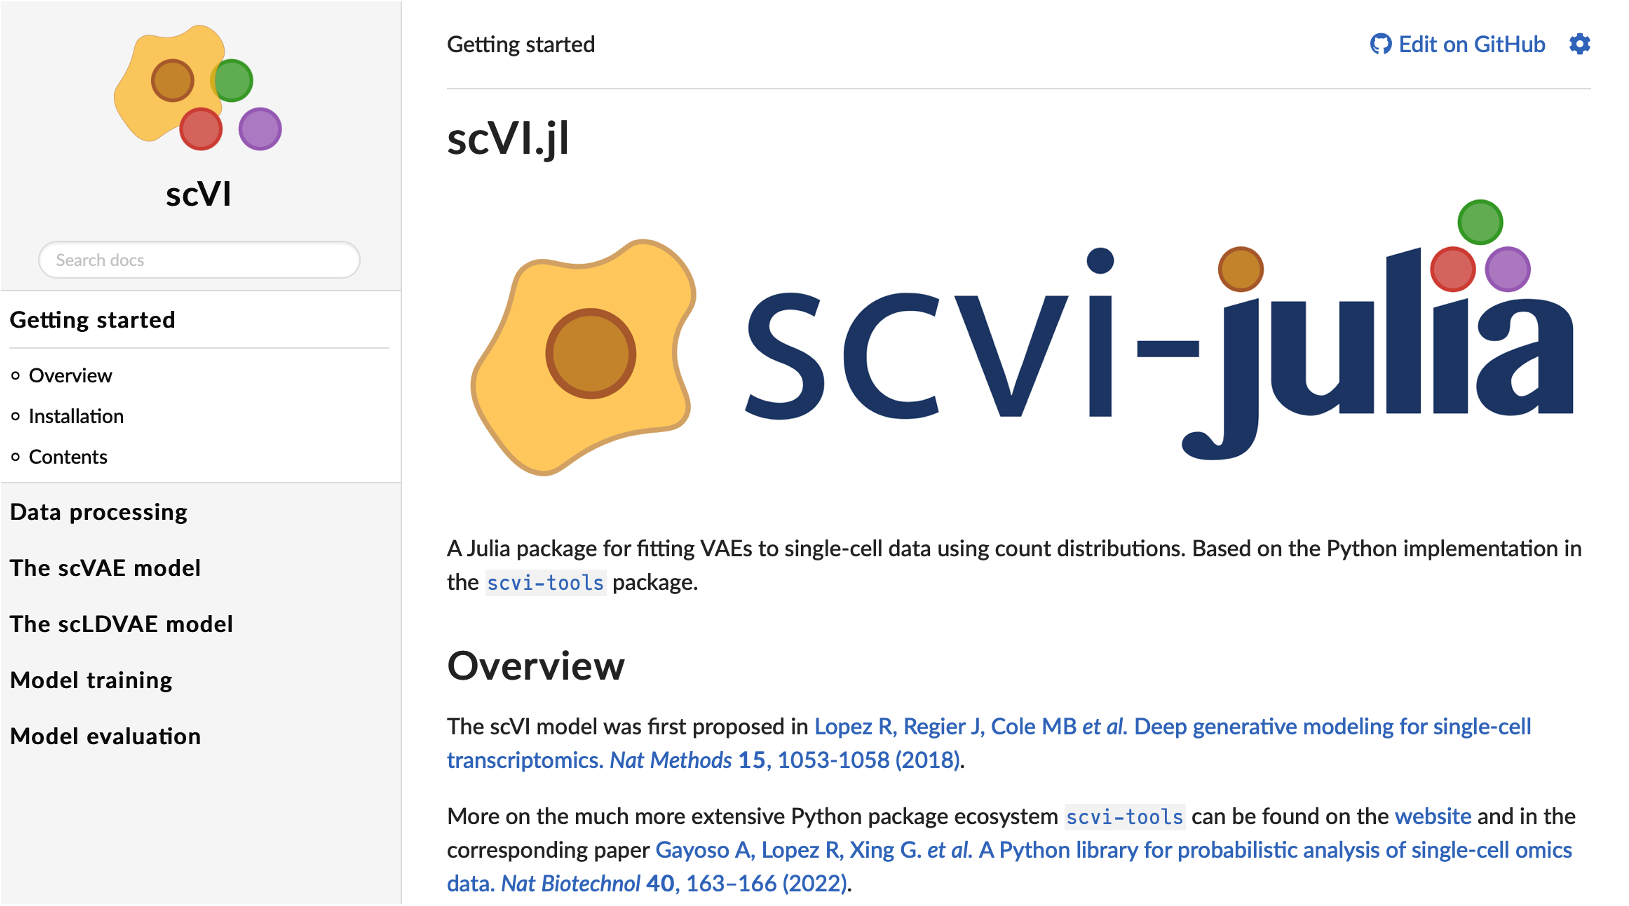

## Comparison: Overview 

| **Approach** | **Basic idea** | **Linear vs. nonlinear** | **Global vs. local structure** | **Deterministic vs. random component** | **Type of input data** | **Hyperparameters** |
|---------|-----------|---------------------|----------------------|-------------|-----------|-----------------|
| PCA      | Rotate data and project to axes of greatest variarion | Linear | Preserves global distances | Deterministic (= gives always the same result, no random component) | Symmetric | None |
| tSNE     | Preserve distributions of distances to nearest neighbors | Nonlinear | Only preserves local distances to nearest neighbors | Stochastic (=result dependent on random initialisation of the embedding)| Roughly Gaussian (in practice typically PCA embedding) | Perplexity (= "how many neighbours to incorporate"); learning rate; number of PCs on which to calculate neighbour graphs|
| UMAP     | Preserve nearest-neighbor based graph structure  | Nonlinear | Focuses on local distances, but preserves some global structure because it embeds the complete graph | Stochastic (=result dependent on random initialiation of graph embedding + sampling edges for the optimisation) | Rescaled / symmetric (in practice typically PCA embedding)|Number of neighbors for the initial KNN graph; number of PCs for the initial KNN graph; minimum distance to neighbors; spread |
| scVI | Uses neural networks to learn a compressed representation by encoding and decoding to and from a latent space | Nonlinear | Can preserve both global and local structure, dependent on loss function | Stochastic (=result depending on random initialisation of the network weights) | Raw counts | Number of epochs (=steps in the training); learning rate; network architecture (`n_layers`, decoder distribution); loss function design |